In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
!mkdir -p /content/data

In [2]:
id = 'your google drive file id'

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={id}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={id}" -O data.zip && rm -rf /tmp/cookies.txt

In [4]:
!unzip -qq -o /content/data.zip -d /content/data

In [5]:
!rm -rf /content/data/__MACOSX

In [6]:
!ls -ltr /content/data/

total 8
drwxr-xr-x 3 root root 4096 Apr 29 07:57 regular
drwxr-xr-x 3 root root 4096 Apr 29 10:45 alert


In [7]:
!ls -ltr /content/data/regular

total 176
drwxr-xr-x 2 root root 180224 Apr 29 07:58 train


#### Library load

In [8]:
import numpy as np
import pandas as pd
import librosa
import os

import matplotlib.pyplot as plt
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image, ImageFile
from skimage.transform import resize
from copy import deepcopy

plt.style.use('seaborn-white')

<ipython-input-8-d48088455d32>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)
print (device)

cuda


### Dataset, Dataloader

In [10]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, label_names, folder='train', input_shape = (64, 64), duration=5, sr=44100, n_fft=1024, n_hop=1024, \
                 n_mfcc=48, n_mels=128, transform=None):
        self.data_dir = data_dir
        self.label_names = label_names
        self.folder = folder
        self.duration = duration
        self.sr = sr
        self.n_fft = n_fft
        self.n_hop = n_hop
        self.n_mfcc = n_mfcc
        self.n_mels = n_mels
        self.input_shape = input_shape
        self.transform = transform
        
        self.data, self.labels = self.load_data()

    def load_data(self):
        data = []
        labels = []
        for i, label in enumerate(self.label_names):
            path = os.path.join(self.data_dir, label, self.folder)
            for audio_file in os.listdir(path):
                if audio_file.lower().endswith(('.wav')):
                    audio_path = os.path.join(path, audio_file)
                    try:
                        full_audio_data, _ = librosa.load(audio_path, sr=self.sr)
                        num_chunks = int(np.ceil(len(full_audio_data) / (self.sr * self.duration)))

                        for chunk_idx in range(num_chunks):
                            start_sample = chunk_idx * self.duration * self.sr
                            end_sample = (chunk_idx + 1) * self.duration * self.sr
                            audio_data = full_audio_data[start_sample:end_sample]
                            
                            stft = np.abs(librosa.stft(audio_data, n_fft=self.n_fft, hop_length=self.n_hop))
                            melspec = librosa.feature.melspectrogram(y=audio_data, sr=self.sr, n_fft=self.n_fft, hop_length=self.n_hop, n_mels=self.n_mels)
                            mfcc = librosa.feature.mfcc(S=librosa.power_to_db(melspec), sr=self.sr, n_mfcc=self.n_mfcc)
                            
                            # Normalize Mel-spectrogram
                            melspec_mean = np.mean(melspec)
                            melspec_std = np.std(melspec)
                            melspec_std += 1e-8  # Add a small value to avoid division by zero
                            melspec_norm = (melspec - melspec_mean) / melspec_std
                            
                            # Normalize MFCC
                            mfcc_mean = np.mean(mfcc)
                            mfcc_std = np.std(mfcc)
                            mfcc_std += 1e-8  # Add a small value to avoid division by zero
                            mfcc_norm = (mfcc - mfcc_mean) / mfcc_std

                            # Resize each feature to the specified input_shape
                            stft_resized = resize(stft, input_shape)
                            melspec_norm_resized = resize(melspec_norm, input_shape)
                            mfcc_norm_resized = resize(mfcc_norm, input_shape)

                            features = np.concatenate((stft_resized, melspec_norm_resized, mfcc_norm_resized), axis=0)
                            
                            data.append(features)
                            labels.append(i)
                    except:
                        print(f"Failed to process audio file: {audio_path}")

        return data, labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx]).float()
        sample = sample.unsqueeze(0)  # Add a channel dimension
        label = self.labels[idx]
        return sample, label


In [44]:
# Define the number of classes
# num_classes = 2 or 6
num_classes = 6
label_names = ['regular', 'help', 'robbery', 'sexual', 'theft', 'violence']
# label_names = ['regular', 'alert']

# Define the path to the directory containing the audio files
data_dir = '/content/data'

# Define the batch size for training and validation
batch_size = 32

# Set the input shape
input_shape = (64, 64)

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

# Create the datasets
dataset = AudioDataset(data_dir, label_names, folder='train',input_shape=input_shape ,transform=transform)

# Split the datasets into training and validation sets
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=358
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=194
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=44
  warnings.warn(


In [68]:
label_to_index = {label: index for index, label in enumerate(label_names)}
label_to_index

{'regular': 0, 'help': 1, 'robbery': 2, 'sexual': 3, 'theft': 4, 'violence': 5}

In [69]:
print (len(train_dataset), len(val_dataset))

9923 2481


In [70]:
train_loader

In [67]:
train_dataset[0][0].shape

torch.Size([1, 192, 64])

In [71]:
# Get the first batch from the train_loader
first_batch = next(iter(train_loader))

# Get the data and labels from the first batch
data, labels = first_batch

# Print the shape of the first object in data
print("Shape of the first object in the train_loader:", data.shape)

Shape of the first object in the train_loader: torch.Size([32, 1, 192, 64])


## Fine Tuning

#### Dense net

In [33]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00


In [61]:
import timm

# densenet
class AudioModel(nn.Module):
    '''
    in_chans 파라미터는 입력 데이터의 채널 수를 나타냅니다.
    각각의 특징(STFT, Mel-spectrogram, MFCC)이 수직 방향으로 연결되므로, 데이터의 채널 수는 1이 됩니다. 이 경우, in_chans 파라미터 값으로 1을 사용해야 합니다.
    '''
    def __init__(self,
                 num_classes,
                 model_name='densenet121',
                 pretrained=True):
        super(AudioModel, self).__init__()

        self.model = timm.create_model(model_name,
                                       pretrained=pretrained,
                                       in_chans=1)
        self.in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(self.in_features, num_classes)
        )

    def forward(self, images):
        logits = self.model(images)
        return logits

#### EfficientNet

In [ ]:
import timm

class AudioModel(nn.Module):
    def __init__(self,
                 num_classes,
                 model_name='efficientnet_b0',
                 pretrained=True):
        super(AudioModel, self).__init__()

        self.model = timm.create_model(model_name,
                                       pretrained=pretrained,
                                       in_chans=4)
        self.in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(self.in_features, num_classes)
        )

    def forward(self, images):
        logits = self.model(images)
        return logits

#### train

In [75]:
def accuracy(y_pred, y_true):
  pred_labels = torch.argmax(y_pred, dim=1)
  correct = pred_labels.eq(y_true).sum().item()
  return correct / len(y_true)

In [77]:
def train_model(model, train_loader, val_loader, optimizer, loss_func, early_stop, n_epochs, progress_interval, device):

    train_losses, valid_losses, train_accs, valid_accs, lowest_loss = list(), list(), list(), list(), np.inf
    stop_counter = 0  # Add a counter to track the number of stagnant epochs

    # Move the model to the GPU
    model = model.to(device)
    # Move the loss function to the GPU
    criterion = loss_func.to(device)

    for epoch in range(n_epochs):

        train_loss, valid_loss, train_acc, valid_acc = 0, 0, 0, 0

        # train the model
        model.train() # prep model for training
        for i, (x_minibatch, y_minibatch) in enumerate(train_loader):
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            y_minibatch_pred = model(x_minibatch)
            loss = criterion(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(y_minibatch_pred, y_minibatch)

            # print progress every 10 batches
            if (i+1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], \
                Train Loss: {train_loss/(i+1):.4f}, Train Acc: {train_acc/(i+1)*100:.2f}%")

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_acc / len(train_loader)
        train_accs.append(train_acc)   

        # validate the model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_loader:
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.to(device)
                y_minibatch_pred = model(x_minibatch)
                _, y_pred_label = torch.max(y_minibatch_pred, dim=1)
                y_true.extend(y_minibatch.cpu().numpy())
                y_pred.extend(y_pred_label.cpu().numpy())

                loss = criterion(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                valid_acc += accuracy(y_minibatch_pred, y_minibatch)

        valid_loss = valid_loss / len(val_loader)
        valid_losses.append(valid_loss)
        valid_acc = valid_acc / len(val_loader)
        valid_accs.append(valid_acc)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
            stop_counter = 0  # Reset the counter if a new best model is found
        else:
            stop_counter += 1  # Increment the counter if no improvement

        if epoch >= early_stop and stop_counter >= early_stop:  # Updated the condition for early stopping
            print("Early Stopped at Epoch", epoch)
            model.load_state_dict(best_model)
            break

        if (epoch % progress_interval) == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Train Loss: {train_losses[-1]:.4f}, \
            Train Acc: {train_accs[-1]*100:.2f}%, Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accs[-1]*100:.2f}%")

    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses, train_accs, valid_accs

In [78]:
import torch.optim as optim

model = AudioModel(num_classes)
# Define the loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

# Train the model
n_epochs = 10
early_stop = 5
progress_interval = 1

y_true, y_pred = [], []
trained_model, lowest_loss, train_losses, valid_losses, train_accs, valid_accs = train_model(model, train_loader, val_loader, optimizer, loss_func, early_stop, n_epochs, progress_interval, device)

Epoch [1/10], Step [10/311],                 Train Loss: 1.5055, Train Acc: 45.94%
Epoch [1/10], Step [20/311],                 Train Loss: 1.2876, Train Acc: 58.91%
Epoch [1/10], Step [30/311],                 Train Loss: 1.1138, Train Acc: 65.83%
Epoch [1/10], Step [40/311],                 Train Loss: 1.0016, Train Acc: 68.91%
Epoch [1/10], Step [50/311],                 Train Loss: 0.9190, Train Acc: 71.44%
Epoch [1/10], Step [60/311],                 Train Loss: 0.8540, Train Acc: 73.07%
Epoch [1/10], Step [70/311],                 Train Loss: 0.8045, Train Acc: 74.73%
Epoch [1/10], Step [80/311],                 Train Loss: 0.7656, Train Acc: 75.98%
Epoch [1/10], Step [90/311],                 Train Loss: 0.7297, Train Acc: 77.26%
Epoch [1/10], Step [100/311],                 Train Loss: 0.7005, Train Acc: 78.09%
Epoch [1/10], Step [110/311],                 Train Loss: 0.6856, Train Acc: 78.49%
Epoch [1/10], Step [120/311],                 Train Loss: 0.6600, Train Acc: 79.48%
E

In [79]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

In [80]:
cm

array([[18165,    59,    21,    46,    37,    32],
       [   34,  1048,    34,    39,    42,    33],
       [    2,     1,  1017,    77,    93,     0],
       [   15,    12,    71,  1097,   105,    20],
       [   35,     6,    42,    64,  1146,    27],
       [   22,    27,    13,    15,    45,  1268]])

In [81]:
from sklearn.metrics import f1_score

# Compute the F1 score
f1 = f1_score(y_true, y_pred, average='macro')

print('F1 score: %.2f' % f1)

F1 score: 0.88


In [82]:
print(f"Training accuracy: {train_accs[-1]*100:.2f}%, Validation accuracy: {valid_accs[-1]*100:.2f}%")
print(f"Training loss: {train_losses[-1]:.4f}, Validation loss: {valid_losses[-1]:.4f}")


Training accuracy: 99.15%, Validation accuracy: 96.96%
Training loss: 0.0271, Validation loss: 0.1125


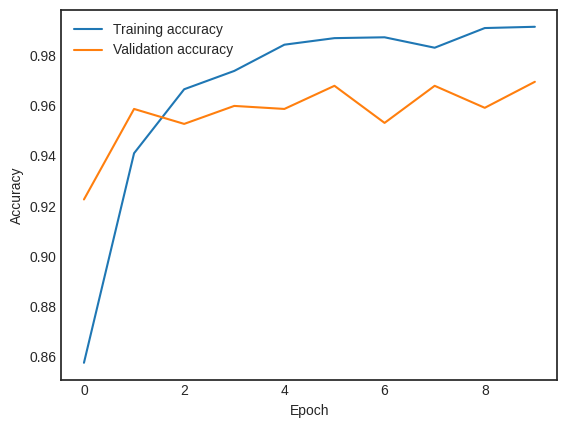

In [83]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Training accuracy')
plt.plot(valid_accs, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

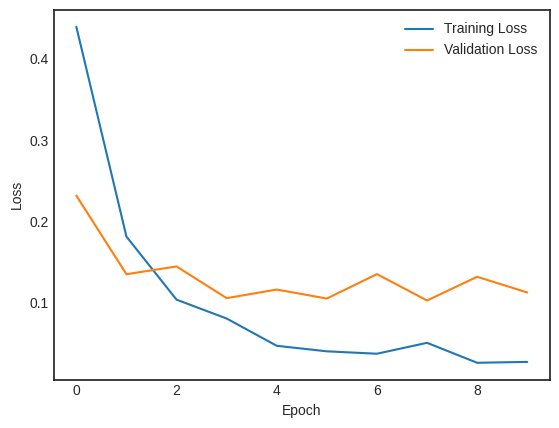

In [84]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### test

In [87]:
# Set the model to evaluation mode
trained_model.eval()

# Initialize the correct and total predictions counters
correct_predictions = 0
total_predictions = 0
y_true, y_pred = [], []
# Loop over the validation data loader
for inputs, labels in val_loader:
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Compute the predicted outputs
    with torch.no_grad():
        outputs = trained_model(inputs)

    # Get the predicted labels
    _, predicted_labels = torch.max(outputs.data, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted_labels.cpu().numpy())
    
    # Update the counters
    total_predictions += labels.size(0)
    correct_predictions += (predicted_labels == labels).sum().item()

# Compute the validation accuracy
val_accuracy = 100.0 * correct_predictions / total_predictions

print(correct_predictions)
print(total_predictions)
print('Validation accuracy: %.2f %%' % val_accuracy)

2401
2481
Validation accuracy: 96.78 %


In [88]:
from sklearn.metrics import f1_score

# Compute the F1 score
f1 = f1_score(y_true, y_pred, average='macro')

print('F1 score: %.2f' % f1)

F1 score: 0.91


In [89]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

cm

array([[1820,    5,    5,    3,    1,    2],
       [   2,  113,    2,    2,    2,    2],
       [   0,    0,  106,    6,    7,    0],
       [   0,    0,    5,  117,    9,    1],
       [   4,    0,    4,    3,  120,    1],
       [   2,    9,    1,    0,    2,  125]])

### save the model

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Define the file path for the saved model
# save_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_cnn.pt'
save_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_ff_densenet_label6.pt'

# Save the trained model
# torch.save(trained_model.state_dict(), save_path)
torch.save({
            'model_state_dict': trained_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, save_path)

# Test with wav

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [100]:
import timm

# densenet
class AudioModel(nn.Module):
    '''
    in_chans 파라미터는 입력 데이터의 채널 수를 나타냅니다.
    각각의 특징(STFT, Mel-spectrogram, MFCC)이 수직 방향으로 연결되므로, 데이터의 채널 수는 1이 됩니다. 이 경우, in_chans 파라미터 값으로 1을 사용해야 합니다.
    '''
    def __init__(self,
                 num_classes,
                 model_name='densenet121',
                 pretrained=True):
        super(AudioModel, self).__init__()

        self.model = timm.create_model(model_name,
                                       pretrained=pretrained,
                                       in_chans=1)
        self.in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(self.in_features, num_classes)
        )

    def forward(self, images):
        logits = self.model(images)
        return logits

In [101]:
import librosa
import numpy as np

import torch
from torchvision.models.resnet import ResNet, BasicBlock
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from skimage.transform import resize


# Define the path to the saved model
model_path = '/content/drive/MyDrive/졸플/Audio/output_128/pytorch_ff_densenet_label6.pt'

# Load the saved model
checkpoint = torch.load(model_path)
model = AudioModel(num_classes=6)
model.load_state_dict(checkpoint['model_state_dict'])

num_classes = 6
label_names = ['regular', 'help', 'robbery', 'sexual', 'theft', 'violence']

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# Move the model to the device
model.to(device)

In [106]:
def predict_audio(audio_file, model, label_names, device,
                  sr=44100, n_fft=1024, hop_length=1024,
                  n_mels=128, n_mfcc=48, input_shape=(64, 64)):
  
    # Load the audio data
    audio_data, sr = librosa.load(audio_file, sr=sr)
    
    # Extract features
    stft = np.abs(librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length))
    melspec = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(melspec), sr=sr, n_mfcc=n_mfcc)

    # Normalize Mel-spectrogram
    melspec_mean = np.mean(melspec)
    melspec_std = np.std(melspec)
    melspec_std += 1e-8  # Add a small value to avoid division by zero
    melspec_norm = (melspec - melspec_mean) / melspec_std

    # Normalize MFCC
    mfcc_mean = np.mean(mfcc)
    mfcc_std = np.std(mfcc)
    mfcc_std += 1e-8  # Add a small value to avoid division by zero
    mfcc_norm = (mfcc - mfcc_mean) / mfcc_std

    # Resize each feature to the specified input_shape
    stft_resized = resize(stft, input_shape)
    melspec_norm_resized = resize(melspec_norm, input_shape)
    mfcc_norm_resized = resize(mfcc_norm, input_shape)

    # Concatenate the features
    features = np.concatenate((stft_resized, melspec_norm_resized, mfcc_norm_resized), axis=0)

    # Convert the features to a PyTorch tensor and add batch and channel dimensions
    sample = torch.tensor(features).float().unsqueeze(0).unsqueeze(0).to(device)

    # Move the model to evaluation mode
    model.eval()

    # Make a prediction
    with torch.no_grad():
        output = model(sample)
        # probabilities = F.softmax(output, dim=1)
        predicted_label = torch.argmax(output, dim=1).item()
        predicted_feature= output

    return label_names[predicted_label], predicted_feature

In [103]:
!ls -lt /content/drive/MyDrive/졸플/Audio/test

total 32732
-rw------- 1 root root 1003598 Apr 29 10:27  20.여기좀도와주세요.wav
-rw------- 1 root root  660428 Apr 19 07:39  output.wav
-rw------- 1 root root  528352 Apr 19 07:34 '1.강제추행(성범죄)_18300_label.wav'
-rw------- 1 root root  401486 Apr 17 13:05 '만지지마세요(남성)-위급.wav'
-rw------- 1 root root  532558 Apr 17 13:05 '만지지마(남성) 장난.wav'
-rw------- 1 root root  732582 Apr 17 12:48  만지지마세요_차분.wav
-rw------- 1 root root  749514 Apr 17 12:47  만지지마세요_하이톤.wav
-rw------- 1 root root  617478 Mar 27 09:05  실외_소리.wav
-rw------- 1 root root  586522 Mar 26 14:32  살려주세요2.wav
-rw------- 1 root root  944262 Mar 26 14:12  16.정상_추가1.wav
-rw------- 1 root root  944262 Mar 26 14:12  20.정상_오늘날씨가너무좋아밖에나가자.wav
-rw------- 1 root root  917582 Mar 16 14:56  baby-sexual.wav
-rw------- 1 root root  917582 Feb 27 08:12  유아-성추행.wav
-rw------- 1 root root 1003598 Feb 26 05:53  유투브-도와주세요.wav
-rw------- 1 r

In [117]:
audio_file1 = '/content/drive/MyDrive/졸플/Audio/test/만지지마(남성) 장난.wav'
audio_file2 = '/content/drive/MyDrive/졸플/Audio/test/만지지마세요_하이톤.wav'

In [118]:
label1, probability1 = predict_audio(audio_file1, model, label_names, device)
print(f"Audio file 1: {audio_file1}\nPredicted label: {label1}\nProbability: {probability1}\n")

label2, probability2 = predict_audio(audio_file2, model, label_names, device)
print(f"Audio file 2: {audio_file2}\nPredicted label: {label2}\nProbability: {probability2}\n")

Audio file 1: /content/drive/MyDrive/졸플/Audio/test/만지지마(남성) 장난.wav
Predicted label: robbery
Probability: tensor([[-0.1618, -0.2095,  0.0732, -2.7186, -2.2530, -0.9823]],
       device='cuda:0')

Audio file 2: /content/drive/MyDrive/졸플/Audio/test/만지지마세요_하이톤.wav
Predicted label: help
Probability: tensor([[-1.4645,  2.2545, -3.3472, -0.7272, -5.3757,  1.4412]],
       device='cuda:0')

